---

## Reinforcement Learning Assignment 3, PART 2

**File:** `a3_part_2_hmanouch_naglispa.ipynb`  
**Author:** Hamid Manouchehri & Naglis Paunksnis  
**Email:** hmanouch@buffalo.edu & naglispa@buffalo.edu  
**Date:** Apr 23, 2025


---

### Description:
Implementing advantage actor-critic algorithm on "cartpole-v1" environment.

---

### License:
This script is licensed under the **MIT License**.  
You may obtain a copy of the License at:  
🔗 [https://opensource.org/licenses/MIT](https://opensource.org/licenses/MIT)

**SPDX-License-Identifier:** MIT

---

### Disclaimer:
> This software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and noninfringement.  
> In no event shall the authors be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the software or the use or other dealings in the software.

---

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import os
import time

/home/hamid/miniconda3/envs/rl_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global Variables

In [2]:
dir_to_save_data = "../../data/assignment_3/part_2/"  # TODO
max_n_episode = 2500  # TODO
decay_rate = 0.001  # TODO
epsilon_start = 1.0
epsilon_end = 0.01
env_name = 'CartPole-v1'
learning_rate = 1e-3  # TODO
n_steps = 100  # TODO
gamma = 0.99  # TODO

n_workers = 1  # TODO
reward_plot_name = 'reward_per_episode_training_one_worker.png'  # TODO
reward_plot_name_test = 'reward_per_episode_test_model_one_worker.png'  # TODO
epsilon_decay_plot_name = 'epsilon_decay_plot_one_worker.png'  # TODO
model_name = 'one_worker.pth'  # TODO

model_dir_name = os.path.join(dir_to_save_data, model_name)

### Custom Functions

In [3]:
def save_plot_as_img(png_plot_name, dir_to_save):
    """ Call this function after plt.plot(...)"""
    
    save_path = os.path.join(dir_to_save, png_plot_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print(f"Plot saved at: {save_path}")

### Defining Neural Networks and Actor-Critic Algorithm

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):

        super(ActorCritic, self).__init__()

        self.fc = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(),)
        self.actor = nn.Linear(128, n_actions)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc(x)
        return self.actor(x), self.critic(x)

def worker(global_model, optimizer, env_name, n_steps, gamma, global_episode,
           lock, rewards_list, epsilon_list):

    env = gym.make(env_name)

    local_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
    local_model.load_state_dict(global_model.state_dict())

    state, _ = env.reset()
    done = False
    total_reward = 0

    while global_episode.value < max_n_episode:  # limit training episodes

        eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-decay_rate * global_episode.value)
        
        eps = max(epsilon_end, eps)
        epsilon_list.append(eps)

        log_probs, values, rewards = [], [], []

        for i in range(n_steps):

            state_tensor = torch.from_numpy(state).float()

            # value = critic_output
            # logits = actor_output
            logits, value = local_model(state_tensor)

            # print(logits)
            probs = torch.softmax(logits, dim=-1)
            # if i%4==0:
            #     print(probs, end='      \r')
            m = Categorical(probs)
            # print(m)

            if np.random.random() < eps:
                # explore: random action
                action = torch.tensor(env.action_space.sample())
            else:
                # exploit: sample from policy
                action = m.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            total_reward += reward

            log_probs.append(m.log_prob(action))
            values.append(value)
            rewards.append(reward)

            state = next_state

            if done:

                state, _ = env.reset()

                with lock:

                    global_episode.value += 1
                    rewards_list.append(total_reward)

                total_reward = 0

                break

        R = torch.zeros(1, 1)
        if not done:

            _, value = local_model(torch.from_numpy(state).float())
            R = value.detach()

        returns = []
        for r in rewards[::-1]:

            R = r + gamma * R

            returns.insert(0, R)

        returns = torch.cat(returns)
        values = torch.cat(values)

        # Q(s,a) - V(s)     or  
        advantage = returns - values

        policy_loss = -(torch.stack(log_probs) * advantage.detach()).mean()

        value_loss = advantage.pow(2).mean()

        optimizer.zero_grad()

        (policy_loss + value_loss).backward()

        for local_param, global_param in zip(local_model.parameters(), global_model.parameters()):

            global_param._grad = local_param.grad

        optimizer.step()
        local_model.load_state_dict(global_model.state_dict())

### Training Model

Plot saved at: ../../data/assignment_3/part_2/reward_per_episode_training_one_worker.png


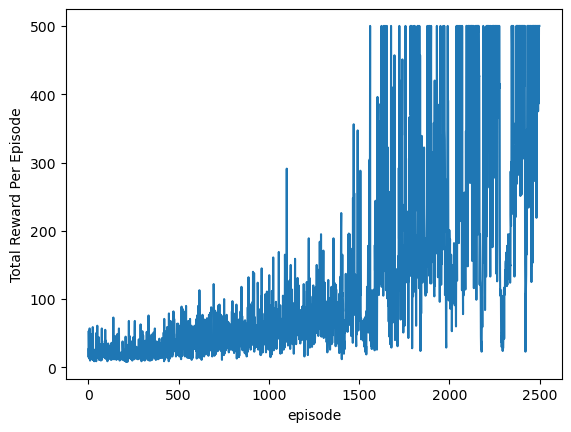

Plot saved at: ../../data/assignment_3/part_2/epsilon_decay_plot_one_worker.png


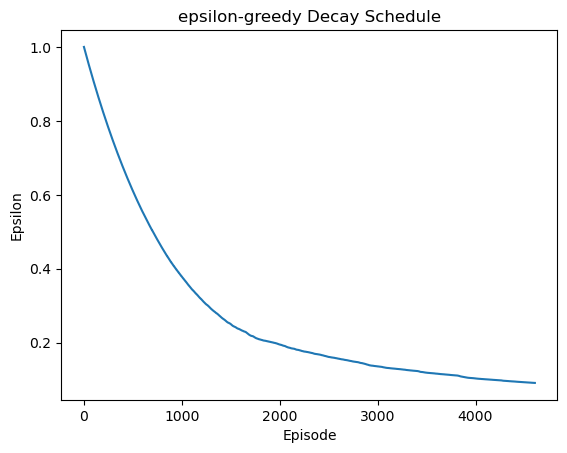

In [5]:
processes = []
global_episode = mp.Value('i', 0)
lock = mp.Lock()
manager = mp.Manager()
rewards_list = manager.list()
epsilon_list = manager.list()

input_dim = gym.make(env_name).observation_space.shape[0]
n_actions = gym.make(env_name).action_space.n

global_model = ActorCritic(input_dim, n_actions)
global_model.share_memory()

optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)

for rank in range(n_workers):

    p = mp.Process(target=worker, args=(global_model, optimizer, env_name, n_steps, gamma,
                                        global_episode, lock, rewards_list, epsilon_list))
    
    p.start()
    processes.append(p)

for p in processes:
    p.join()

plt.plot(rewards_list)
save_plot_as_img(reward_plot_name, dir_to_save_data)
plt.xlabel('episode')
plt.ylabel('Total Reward Per Episode')
plt.show()

plt.plot(np.array(epsilon_list))
save_plot_as_img(epsilon_decay_plot_name, dir_to_save_data)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('epsilon-greedy Decay Schedule')
plt.show()

torch.save(global_model.state_dict(), model_dir_name)


### Test the trained model and rendering

Episode 0 reward: 500.0
Episode 1 reward: 500.0
Episode 2 reward: 500.0
Episode 3 reward: 500.0
Episode 4 reward: 500.0
Episode 5 reward: 500.0
Episode 6 reward: 500.0
Episode 7 reward: 500.0
Episode 8 reward: 500.0
Episode 9 reward: 500.0
Plot saved at: ../../data/assignment_3/part_2/reward_per_episode_test_model_one_worker.png


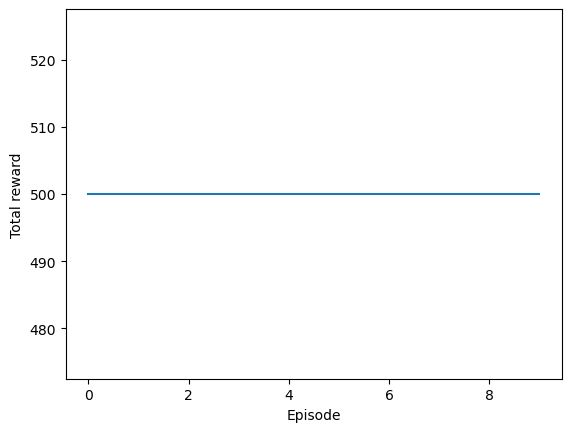

In [6]:
n_episode = 10
fps = 100
total_rewards = []

env = gym.make(env_name, render_mode='human')
input_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model = ActorCritic(input_dim, n_actions)
model.load_state_dict(torch.load(model_dir_name))
model.eval()

for ep in range(n_episode):

    state, _ = env.reset()
    done = False
    total_reward = 0   # reset the reward per episode

    while not done:

        env.render()
        time.sleep(1/fps)

        # greedy action
        state_tensor = torch.from_numpy(state).float()
        logits, _ = model(state_tensor)
        action = torch.argmax(logits).item()

        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        total_reward += reward

    total_rewards.append(total_reward)
    print(f"Episode {ep} reward:", total_reward)

env.close()

plt.plot(range(n_episode), total_rewards)
save_plot_as_img(reward_plot_name_test, dir_to_save_data)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
